---
title: 'Bank Loans'
author: 'Andre Xiao'
date: '2024-03-03'
image: "loans.webp"
description: "Optimizing and assessing the impact of an automated decision system for bank loans."
format: html
code-annotations: hover
number-sections: true
---

![Image source: techfunnel.com](https://www.techfunnel.com/wp-content/uploads/2021/07/benefits_of_business_loans.png)

## Overview

This study attempts to optimize the maximum total expected profit from loans for an unknown bank. I will be trying to create an automated decision-making sytem that gives each prospective borrower a score and decides whether to give them a loan based on a threshold, $t$, where each score, $s_i$, of borrower, $i$, is defined as
$$s_i = \langle \mathbf{X}_i, \mathbf{w} \rangle$$ {#eq-score}
where $\mathbf{X}_i$ is the vector of features for borrower, $i$, and $\mathbf{w}$ is the vector of weights for each feature.
Using this, the goal is to find $\mathbf{w}$ and $t$ which maximize the total expected profit per loan for the bank.

To accomplish this, I use logistic regression to determine $\mathbf{w}$ and calculate the expected profit per loan for various $t$-values. In this study, we assume that each loan is a 10-year loan and 75% of the interest is used to pay for operating costs such as employee salaries. We also assume that defaults occur after three years and the bank loses 70% of the principal. That is,
$$\begin{align*}
    \textbf{profit} &= \text{loan amount}\cdot(1+0.25\cdot\text{interest rate})^{10} - \text{loan amount} \\
    \textbf{cost} &= \text{loan amount}\cdot(1+0.25\cdot\text{interest rate})^3 - 1.7\cdot\text{loan amount}
\end{align*}$$ {#eq-profit-cost}

In the end, the expected profit per loan for the bank was $1714.51.

Afterwards, I discuss the impact that the automated system has on different segments of the population of prospective borrowers. I explore how the system impacts different age groups, purposes for the loan request, and income levels. I find that it is easier for younger age groups to receive loans, harder to take out student loans and loans for ventures, and it is much easier for higher income-levels to receive loans under my system.



## Preparing the Training Data

In [1]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

The dataset contains the following columns:

- `person_age`: the age of the prospective borrower.
- `person_income`: the income of the prospective borrower at the time of application.
- `person_home_ownership`: the home ownership status of the prospective borrower at the time of application. Possible values are `MORTGAGE`, `OWN`, `RENT`, and `OTHER`.
- `person_emp_length`: the length of the most recent employment for the prospective borrower, in years.
- `loan_intent`: the purpose of the loan request.
- `loan_grade`: a composite measure of the likelihood of the borrower to repay the loan. **My system will give its own score to each borrower.**
- `loan_amnt`: the amount of the loan.
- `loan_int_rate`, the annual interest rate on the loan in percent. **This is the target variable.**
- `loan_status`: whether (`1`) or not (`0`) the borrower defaulted on the loan.
- `loan_percent_income`: the amount of the loan as a proportion of the prospective borrower’s personal income. This is caluculated as `loan_amnt`/`person_income`.
- `cb_person_default_on_file`: whether the prospective borrower has previously defaulted on a loan in the records of a credit bureau.
- `cb_person_cred_hist_length`: the length of credit history of the prospective borrower, in years.

In addition to the columns given by the data set, I will add another column:

- `int_percent_income`: the amount of yearly interest as a proportion of the borrower's income. Calculated as `int_percent_income = loan_percent_income * loan_int_rate`.

I will also be changing `loan_int_rate` from a percentage to a fraction before calculating `int_percent_income`.

In [2]:
def prepare_data(df): # <1>
    df_ = df.copy() # <2>
    df_ = df_.dropna() # <3>                          
    df_['loan_int_rate'] = df_['loan_int_rate'] / 100 # <4>
    df_['int_percent_income'] = df_['loan_percent_income'] * df_['loan_int_rate'] # <5>
    df_ = df_[(df_['person_age'] <= 100) & (df_['person_emp_length'] <= 100)] # <6>
    return df_

df_train = prepare_data(df_train)
df_train.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,int_percent_income
1,27,98000,RENT,3.0,EDUCATION,C,11750,0.1347,0,0.12,Y,6,0.016164
2,22,36996,RENT,5.0,EDUCATION,A,10000,0.0751,0,0.27,N,4,0.020277
3,24,26000,RENT,2.0,MEDICAL,C,1325,0.1287,1,0.05,N,4,0.006435
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,0.0963,0,0.28,N,10,0.026964
6,21,21700,RENT,2.0,HOMEIMPROVEMENT,D,5500,0.1491,1,0.25,N,2,0.037275


1. Function to prepare data.
2. Copy dataframe
3. Drop all NaNs
4. Converts `loan_int_rate` to fraction from percent.
5. Calculates `int_percent_income` and add it as a new column.
6. Drops all people over the age of 100 and have employment lengths over 100 years.

## Exploring the Data

Let's first take a look at how the loan interest rate and the yearly interest amount as a proportion of income (loan percent of income) relates to whether or not a borrower will default. The reason this may be a good place to start is because it is intuitive to think that a higher interest rate could result in more defaults. Additionally, it is also intuitive to think that the larger the loan amount is compared to a person's income, the chance of defaulting increases. So, we can put these ideas together and conclude that interest rates and the loan percent of income of income could be closely related to the chance of defaulting.

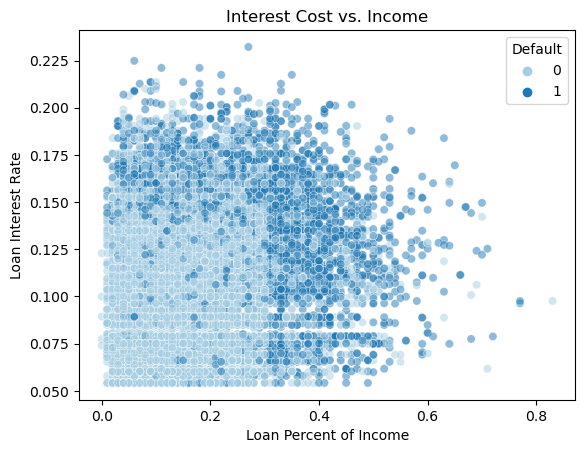

In [3]:
#| code-fold: true
#| label: fig-int-percent-income
#| fig-cap: 'Defaults by interest percent of income.'

import seaborn as sns
import matplotlib.pyplot as plt

pltt = 'Paired'

int_income_plt = sns.scatterplot(df_train,
                                 x = 'loan_percent_income',
                                 y = 'loan_int_rate',
                                 hue = 'loan_status',
                                 palette = pltt,
                                 alpha = 0.5)

int_income_plt.set(xlabel = 'Loan Percent of Income',
                   ylabel = 'Loan Interest Rate',
                   title = 'Interest Cost vs. Income')

int_income_plt.legend(title = 'Default');

As we can see, most defaults occur along the outer ring (dark blue dots). This confirms our intuition. As interest rate increases, more defaults occur and the same can be seen with the loan percent of income. Additionally, this figure (@fig-int-percent-income) provides a good visualization of the interest percent of income (`int_percent_income`). With that said, `loan_int_rate`, `loan_percent_income`, and `int_percent_income` seem like good features to use.

Next, let's try to find some features that agree with this pattern. First, let's take a look at `loan_intent`.

In [4]:
#| code-fold: true
#| label: tbl-loan-intent
#| tbl-cap: 'Loan interest rate, loan percent of income, interest percent of income, and proportion of defaults by loan intent.'

df_train.groupby(["loan_intent"]).agg({'loan_status':'mean', # <1>
                                       'loan_int_rate': 'mean', # <1>
                                       'loan_percent_income':'mean', # <1>
                                       'int_percent_income':'mean'}) # <1>

,loan_status,loan_int_rate,loan_percent_income,int_percent_income
loan_intent,,,,
DEBTCONSOLIDATION,0.282983,0.110173,0.170322,0.019230
EDUCATION,0.171012,0.109952,0.168219,0.018827
HOMEIMPROVEMENT,0.258327,0.111819,0.164516,0.018924
MEDICAL,0.264455,0.110711,0.172422,0.019511
PERSONAL,0.191385,0.110282,0.167568,0.018898
VENTURE,0.146221,0.109690,0.169147,0.018907


1. Get mean of `loan_status`, `loan_int_rate`, `loan_percent_income`, and `int_percent_income` grouped by `loan_intent`.

From the table, we can see that the loan interest rate, loan percent income, and interest percent income are fairly similar between all categories of loan intent. However, there is a remarkable difference in default rates. `DEBTCONSOLODATION`, `HOMEIMPROVEMENT`, and `MEDICAL` all have much higher default rates than the other three categories. This doesn't align well with our findings from @fig-int-percent-income since the default rates don't align with `loan_int_rate`, `loan_percent_income`, and `int_percent_income`. As such, `loan_intent` may not be a good predictor.

Next, we will look at `person_home_ownership`.

In [5]:
#| code-fold: true
#| label: tbl-home-ownership
#| tbl-cap: 'Loan interest rate, loan percent of income, interest percent of income, and proportion of defaults by home ownership status.'

df_train.groupby(["person_home_ownership"]).agg({'loan_status':'mean', # <1>
                                                 'loan_int_rate': 'mean', # <1>
                                                 'loan_percent_income':'mean', # <1>
                                                 'int_percent_income':'mean'}) # <1>

,loan_status,loan_int_rate,loan_percent_income,int_percent_income
person_home_ownership,,,,
MORTGAGE,0.124496,0.105270,0.151172,0.016350
OTHER,0.272727,0.120592,0.189870,0.024013
OWN,0.071429,0.109466,0.184076,0.020363
RENT,0.309761,0.114524,0.180943,0.021013


1. Get mean of `loan_status`, `loan_int_rate`, `loan_percent_income`, and `int_percent_income` grouped by `person_home_ownership`.

Unlike `loan_intent` (@tbl-loan-intent), `person_home_ownership` matches our findings from @fig-int-percent-income. The default rates mostly lineup with `loan_int_rate`, `loan_percent_income`, and `int_percent_income` except for people who `OWN` a home, who have a relatively high `loan_percent_income` and `int_percent_income`, but have the lowest default rates. It is important to note however, that people who `OWN` a home have the second lowest `loan_int_rate`. 

Additionally, as we can see below (@fig-home-intent), `RENT` and `OTHER` have a relatively high amount of borrowers who are using the loans for `DEBTCONSOLIDATION` and `MEDICAL`. This matches up with the findings from @tbl-loan-intent. It seems that `person_home_ownership` is also a decent proxy for `loan_intent` while also matching the findings of @fig-int-percent-income.

As such, we can expect `person_home_ownership` to possibly be a good predictor.

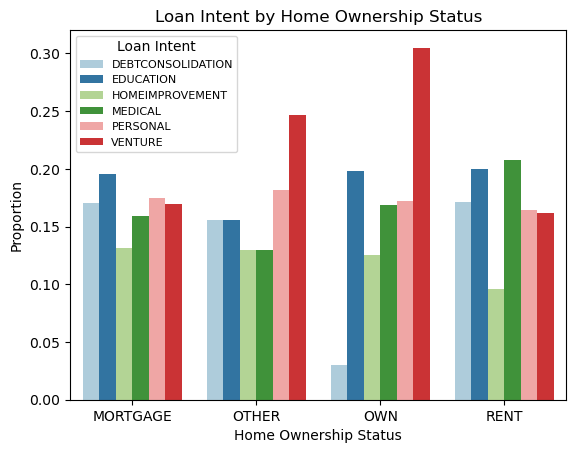

In [6]:
#| code-fold: true
#| label: fig-home-intent
#| fig-cap: 'Loan intent by home ownership status.'

home_intent = ((df_train.groupby(['person_home_ownership', 'loan_intent']).size() # <1>
                / df_train.groupby(['person_home_ownership']).size()) # <1>
                .rename('proportion') # <2>
                .reset_index()) # <3>

home_intent_plt = sns.barplot(home_intent, #<4>
            x = 'person_home_ownership', #<4>
            y = 'proportion', #<4>
            hue = "loan_intent", # <4>
            palette = pltt) # <4>

home_intent_plt.set(xlabel = "Home Ownership Status",
                   ylabel = "Proportion", 
                   title = "Loan Intent by Home Ownership Status")

home_intent_plt.legend(title = "Loan Intent",
                       fontsize = '8');

1. Proportion of each `loan_intent` category for each `person_home_ownership` category.
2. Renames (1) to `proportion`.
3. Resets index.
4. Plots loan intent by home ownership status.

Lastly, let's look at how age relates to `loan_int_rate`, `loan_percent_income`, `int_percent_income`, and default rates. To do this, I created age ranges of 10 years (20's, 30's, 40's, etc.).

In [7]:
#| code-fold: true
#| label: tbl-age-group
#| tbl-cap: 'Loan interest rate, loan percent of income, interest percent of income, and proportion of defaults by age group.'

import numpy as np

age_labels = ["20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"] # <1>
age_bins = np.concatenate((np.arange(19, 80, 10), [150])) # <2>

def get_age_groups(df): # <3>
    df["age_group"] = pd.cut(x = df['person_age'], bins = age_bins, labels = age_labels) # <3>
    return df #<3>

df_train = get_age_groups(df_train) # <4>

df_train.groupby(["age_group"]).agg({'loan_status':'mean', # <5>
                                     'loan_int_rate': 'mean', # <5>
                                     'loan_percent_income':'mean', # <5>
                                     'int_percent_income':'mean'}) # <5>

,loan_status,loan_int_rate,loan_percent_income,int_percent_income
age_group,,,,
20-29,0.220637,0.110169,0.171090,0.019270
30-39,0.200233,0.110843,0.164211,0.018574
40-49,0.193648,0.110663,0.160727,0.018248
50-59,0.221622,0.111235,0.149243,0.016920
60-69,0.318182,0.109743,0.202955,0.022861
70-79,0.142857,0.107500,0.115714,0.011406
80+,0.000000,0.096100,0.110000,0.010571


1. List of age group labels.
2. Set's bins to [19, 29, 39, ..., 79, 150].
3. Function that creates a new column called `age_group` and groups ages into 10 year intervals.
4. Adds `age_group` to `df_train`.
5. Get mean of `loan_status`, `loan_int_rate`, `loan_percent_income`, and `int_percent_income` grouped by `age_group`.

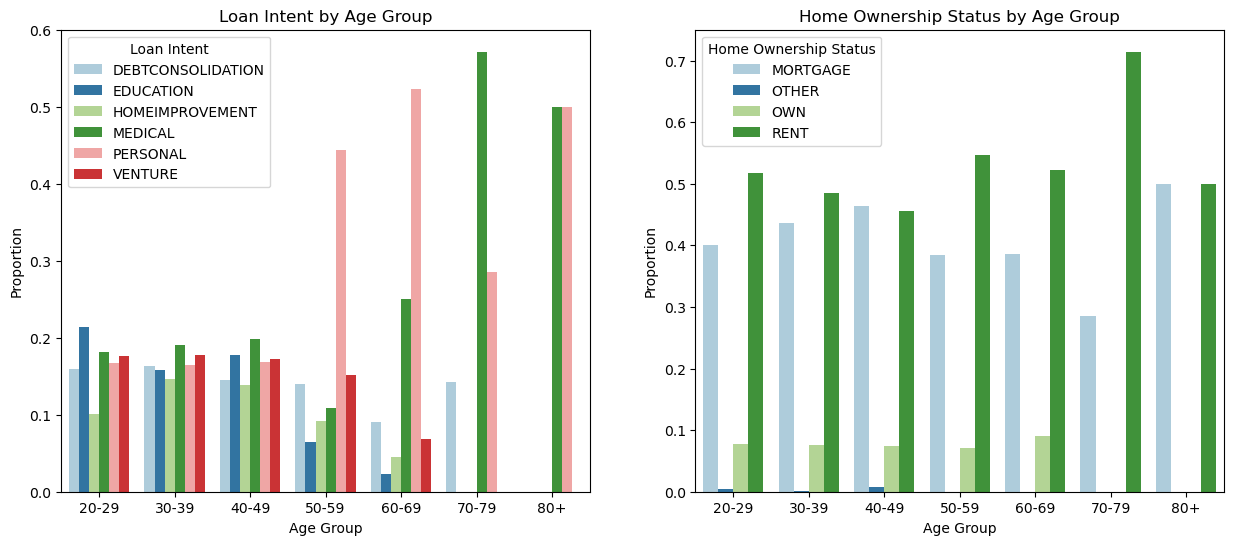

In [8]:
#| code-fold: true
#| label: fig-age-intent-home
#| fig-cap: 'Loan intent and homeownership status by age group.'

age_intent = ((df_train.groupby(['age_group', 'loan_intent']).size() # <1>
               / df_train.groupby(['age_group']).size()) # <1>
               .rename('proportion') # <2>
               .reset_index()) # <3>

fig, ax = plt.subplots(1, 2, figsize = (15, 6)) # <4>

age_intent_plt = sns.barplot(age_intent, # <5>
                             x = 'age_group', # <5>
                             y = 'proportion', # <5>
                             hue = 'loan_intent', # <5>
                             palette = pltt, # <5>
                             ax = ax[0]) # <5>

age_intent_plt.set(xlabel = "Age Group",
                ylabel = "Proportion", 
                title = "Loan Intent by Age Group")

age_intent_plt.legend(title = "Loan Intent")

age_home = ((df_train.groupby(['age_group', 'person_home_ownership']).size() # <6>
             / df_train.groupby(['age_group']).size()) # <6>
             .rename('proportion') # <7>
             .reset_index()) # <8>

age_home_plt = sns.barplot(age_home, # <9>
                             x = 'age_group', # <9>
                             y = 'proportion', # <9>
                             hue = 'person_home_ownership', # <9>
                             palette = pltt, # <9>
                             ax = ax[1]) # <9>

age_home_plt.set(xlabel = "Age Group",
                ylabel = "Proportion", 
                title = "Home Ownership Status by Age Group")

age_home_plt.legend(title = "Home Ownership Status");

1. Proportion of each `loan_intent` category for each `age_group` category.
2. Renames (1) to `proportion`.
3. Resets index.
4. Create 2 subplots.
5. Plots loan intent by age group as first subplot.
6. Proportion of each `person_home_ownership` category for each `age_group` category.
7. Renames (6) to `proportion`.
8. Resets index.
9. Plots home ownership status by age group as second subplot.

From @tbl-age-group, we can see that `age_group` follows the trend found in @fig-int-percent-income with the exception for 50-59 year olds who have a higher default rate despite having a relatively low `loan_percent_income` and `int_percent_income`. However, they do have the highest `loan_int_rate` out of all the age groups which may be a reason as to why their default rates are so high.

Then, comparing `age_group` with `loan_intent` (@fig-age-intent-home), we can see that as borrowers get older, they spend more on `MEDICAL`. Yet despite spending the most on `MEDICAL`, 70-79 year olds have the lower default rates by far which contradicts our findings from @tbl-loan-intent. Additionally, there is no clear relationship between `age_group` and `person_home_ownership`.

Therefore, we can most likely conclude that `age_group` is not a good predictor.

## Finding a Threshold

Using our findings, I will attempt to find an optimal threshold which will maximize expected profit from loans for the bank. I will do this by finding the best features through a semi-exhaustive search, then using those features, for logistic regression. I will then use the coefficients from the trained model as my weight vector, `w`, to compute the score, `s`, for each borrower (@eq-score).

Lastly, I will test multiple thresholds to find the optimal threshold that maximizes expected profit per loan for the bank. The base profit to beat,assuming that the bank gives everyone loans, is $819.12.

In [9]:
gain = ((df_train[df_train['loan_status'] == 0]['loan_amnt'] # <1>
         *(1 + 0.25*df_train['loan_int_rate'])**10 # <1>
         - df_train[df_train['loan_status'] == 0]['loan_amnt']) # <1>
         .sum()) # <1>
cost = ((df_train[df_train['loan_status'] == 1]['loan_amnt'] # <2>
         *(1 + 0.25*df_train['loan_int_rate'])**3 # <2>
         - 1.7*df_train[df_train['loan_status'] == 1]['loan_amnt']) # <2>
         .sum()) # <2>
base_profit = (gain+cost)/df_train.shape[0] # <3>
base_profit # <4>

819.1210295903265

1. Calculates gain from giving out loans to everyone.
2. Calcultaes cost from giving out loans to everyone.
3. Calculates total base profit.
4. Outputs total base profit

Before I start however, I need to prepare the data for training. I will drop our target variable `loan_status` and the bank's "score" for each borrower, `loan_grade`, since I will generate my own scores for each borrower. We also drop `age_group` since we can simply use `person_age` instead, and one-hot encode all the qualitative columns.

In [10]:
#| code-fold: true

y_train = df_train['loan_status'] # <1>
X_train = df_train.drop(['loan_status', 'loan_grade', 'age_group'], axis = 1) # <2>

qual_cols = list(X_train.select_dtypes(exclude=['number']).columns) # <3>
X_train = pd.get_dummies(X_train,
                          columns = qual_cols) # <4>

X_train.head() # <5>

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,int_percent_income,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,27,98000,3.0,11750,0.1347,0.12,6,0.016164,False,False,False,True,False,True,False,False,False,False,False,True
2,22,36996,5.0,10000,0.0751,0.27,4,0.020277,False,False,False,True,False,True,False,False,False,False,True,False
3,24,26000,2.0,1325,0.1287,0.05,4,0.006435,False,False,False,True,False,False,False,True,False,False,True,False
4,29,53004,2.0,15000,0.0963,0.28,10,0.026964,True,False,False,False,False,False,True,False,False,False,True,False
6,21,21700,2.0,5500,0.1491,0.25,2,0.037275,False,False,False,True,False,False,True,False,False,False,True,False


1. Set `loan_status` as my target variable $y$.
2. Drops `loan_status`, `loan_grade`, and `age_group` and set the resulting dataframe to be my features $x$.
3. Get all qualitative columns.
4. One-hot encodes the qualitative columns.

Now that the data is ready to be trained, I will first use my findings from `@fig-int-percent-income` as a starting point. My initial features will be `loan_int_rate`, `loan_percent_income`, and `int_percent_income`.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
want_cols = ['loan_int_rate', 'loan_percent_income', 'int_percent_income'] # <1>

LR = LogisticRegression() # <2>
cross_val_score(LR, X_train[want_cols], y_train, cv = 5).mean() # <3>

0.8256407088706057

1. Sets a list `cols` with my intial column names.
2. Initialize logistic regression instance.
3. Outputs the mean of cross-validation using five folds.

A score of $\approx .83$ is a good start. Now I will try to find other features that may improve the score. I do this by making a power set from the rest of the columns and testing each with `loan_int_rate`, `loan_percent_income`, and `int_percent_income` using five-fold cross validation.

In [12]:
from itertools import chain, combinations

def power_set(iterable): # <1>
    '''power_set([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)''' # <1>
    s = list(iterable) # <1>
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1)) # <1>

all_qual_cols = (list({col.rsplit('_', 1)[0] # <2>
                       for col in X_train.select_dtypes(exclude=['number']).columns})) # <2>
all_quant_cols = list(X_train.select_dtypes(exclude=["bool_","object_"]).columns) # <3>
excess_cols = all_qual_cols + all_quant_cols[0:4] + all_quant_cols[6:8] # <4>


def power_set_cols(df, cols): # <5>
    power_cols = list(list(s) for s in power_set(cols))[1:] # <5>

    for i in range(0, len(power_cols)): # <5>
        all_cols = [] # <5>
        for col in power_cols[i]: # <5>
            all_cols = all_cols + [x_col for x_col in df.columns if col in x_col] # <5>
            power_cols[i] = all_cols # <5>
    return power_cols # <5>

power_cols = [list(p) for p in power_set_cols(X_train, excess_cols)] # <6>
all_cols = [want_cols] + [want_cols + p for p in power_cols] # <7>

1. Function for creating a power set of a list.
2. Gets all qualitative columns without one-hot encoded suffixes (ex. `person_home_ownership_MORTGAGE` $\to$ `person_home_ownership`)
3. Gets all quantitative columns.
4. Combines (2) and (3) together.
5. Function that creates a power set of (4) then adds all one-hot encoding suffixes back for each set in power set (ex. `person_home_owndership_MORTGAGE`, `person_home_ownership_RENT`, etc. for `person_home_ownership`).
6. Converts all sets in power set to lists.
7. Prepends `want_cols` to front of every list in power set.

Here's what one such combination looks like.

In [13]:
all_cols[123]

['loan_int_rate',
 'loan_percent_income',
 'int_percent_income',
 'person_income',
 'loan_amnt',
 'cb_person_cred_hist_length']

Using the list of column combinations, I compare the mean of the cross-validation scores for each one and store the columns that have the best score.

In [14]:
def cross_val(model, cv): # <1>
  best_score = ([], 0) # <1>
  for col in all_cols: # <1>
    cv_scores = cross_val_score(model, X_train[col], y_train, cv = cv) # <1>
    col_scores = (col, cv_scores.mean()) # <1>
    if col_scores[1] > best_score[1]: # <1>
      best_score = col_scores # <1>
  return best_score # <1>

best_score = cross_val(LR, 5)
best_score

(['loan_int_rate',
  'loan_percent_income',
  'int_percent_income',
  'person_home_ownership_MORTGAGE',
  'person_home_ownership_OTHER',
  'person_home_ownership_OWN',
  'person_home_ownership_RENT'],
 0.8474301677042732)

1. Uses cross-validation to find the best scores and returns ([best columns], best score).

We can see that the best columns confirm the findings from exploring the data. With these columns, I can now train my model using logistic regression.

In [15]:
cols = best_score[0]

LR.fit(X_train[cols], y_train)
score = LR.score(X_train[cols], y_train)

score

0.8469499148508799

Below are the coefficients which I will use as the weights for my score function.

In [16]:
w = LR.coef_[0]
w

array([20.43778674,  8.01023218,  2.22540065, -0.0730397 ,  0.36076484,
       -1.18065954,  0.8942643 ])

My score(@eq-score) function:

In [17]:
def linear_score(X, w):
    return X@w

With my score function, I can now give each borrower a score and test various thresholds by profit per loan (@fig-thresh-profit).

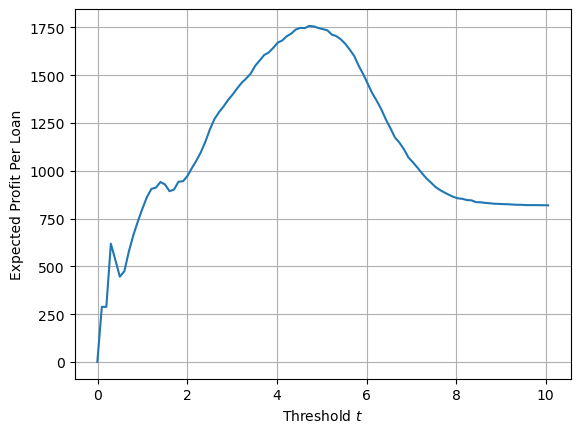

In [18]:
#| label: fig-thresh-profit
#| fig-cap: Expected profit per loan for threshold $t$.

num_thresholds = 101
profit = np.zeros(num_thresholds) # <1>

s = linear_score(X_train[cols], w) # <2>
T = np.linspace(s.min()-0.1, s.max()+0.1, num_thresholds) # <3>
for i in range(num_thresholds):
    y_pred = s >= T[i] # <4>
    TN = X_train[((y_pred == 0) & (y_train == 0))] # <5>
    FN = X_train[((y_pred == 0) & (y_train == 1))] # <6>
    gain = (TN['loan_amnt']*(1 + 0.25*TN['loan_int_rate'])**10 - TN['loan_amnt']).sum() # <7>
    cost = (FN['loan_amnt']*(1 + 0.25*FN['loan_int_rate'])**3 - 1.7*FN['loan_amnt']).sum() # <8>
    total_loans = TN.shape[0] + FN.shape[0] # <9>
    if total_loans == 0: # <10>
        profit[i] = 0
    else:
        profit[i] = (gain + cost) / total_loans

profit_plt = sns.lineplot(x = T, y = profit) # <11>
profit_plt.grid()
profit_plt.set(xlabel = r"Threshold $t$", ylabel = "Expected Profit Per Loan");

1. Initialize profit vector with 0s.
2. Vector of scores for each borrower.
3. Vector of 100 thresholds to test from $[\max(s)-1, \max(s)+1]$.
4. Vector of predictions for score $\geq$ threshold (defaults).
5. True negatives.
6. False negatives.
7. See @eq-profit-cost.
8. See @eq-profit-cost.
9. Total number of loans. (Cost is negative.)
10. Sets profit[i] to 0 if no loans are made, otherwise to expected profit per loan.
11. Plots expected profit per loan for every threshold $t$.

In [19]:
max_profit_index = np.argmax(profit)
profit
t = T[max_profit_index]
p = max(profit)
t, p


(4.721345771117955, 1757.8292670626274)

It looks like the best threshold is approximately `4.72` and the max expected profit per loan is approximately `$1757.83`. With weights, `w`, and threshold `t`, I am now ready to test the model.

## Evaluating the Model from the Bank's Perspective

First, we need to prepare our testing data. I use the same method as my training data.

In [20]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)
df_test = prepare_data(df_test)
y_test = df_test['loan_status']
X_test = df_test.drop(['loan_status', 'loan_grade'], axis = 1)
X_test = pd.get_dummies(df_test,
                        columns = qual_cols)

I use my weight vector, `w`, and my threshold `t` to compute the expected profit per loan for the bank using the testing data.

In [21]:
num_thresholds = 101

s = linear_score(X_test[cols], w)

# t = 4.721345771117955
y_pred = s >= t
TN = X_test[((y_pred == 0) & (y_test == 0))]
FN = X_test[((y_pred == 0) & (y_test == 1))]
gain = (TN['loan_amnt']*(1 + 0.25*TN['loan_int_rate'])**10 - TN['loan_amnt']).sum()
cost = (FN['loan_amnt']*(1 + 0.25*FN['loan_int_rate'])**3 - 1.7*FN['loan_amnt']).sum()
total_loans = TN.shape[0]+FN.shape[0]
profit = (gain + cost) / total_loans

profit

1714.514369055408

Using my model, the bank can expect to make about `$1714.51` per loan, slightly less than the training set.

## Evaluating the Model from the Borrower's Perspective

An important aspect of good machine learning models is fairness and minimal bias. I will be exploring the impact of my autonomous decision-making system on different segments of the population of borrowers by `age_group`, `loan_intent`, and `income_level`.

### Loans by Age

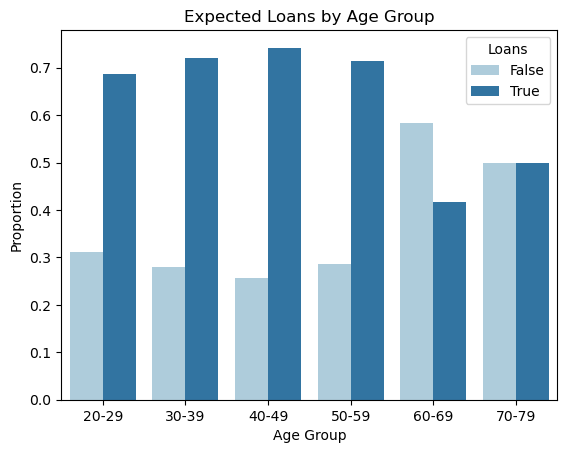

In [22]:
#| code-fold : true
#| label: fig-loans-age
#| fig-cap: Expected loans by age group.


age_labels = ["20-29", "30-39", "40-49", "50-59", "60-69", "70-79"]
age_bins = np.concatenate((np.arange(19, 70, 10), [150]))
df_test = get_age_groups(df_test)

df_test['y_pred'] = y_pred

age_loans = (1-(df_test.groupby(['age_group','y_pred']).size() / df_test.groupby(['age_group']).size())).rename('proportion').reset_index()
age_loans['y_pred'] = age_loans['y_pred'].astype('string')

age_loans_plt = sns.barplot(age_loans,
            x = 'age_group',
            y = 'proportion',
            hue = 'y_pred',
            palette = pltt)

age_loans_plt.set(xlabel = 'Age Group',
                  ylabel = 'Proportion',
                  title = 'Expected Loans by Age Group')

age_loans_plt.legend(title = 'Loans');

From @fig-loans-age, we can see that people older than 60 will have a much harder time getting a loan with only about 40% being approved of taking a loan.

### Loan Intent

In [23]:
#| code-fold : true
#| label: tbl-intent-diff
#| tbl-cap: Difference in actual and predicted loan rates by loan intent.

intent_loans = (1-df_test.groupby(['loan_intent']).agg({'loan_status':'mean', 'y_pred':'mean'})).reset_index().rename({'loan_status':'actual', 'y_pred':'predicted'}, axis = 1)
intent_loans['difference'] = intent_loans['predicted'] - intent_loans['actual']
intent_loans


,loan_intent,actual,predicted,difference
0,DEBTCONSOLIDATION,0.712389,0.676991,-0.035398
1,EDUCATION,0.832483,0.693878,-0.138605
2,HOMEIMPROVEMENT,0.750000,0.756494,0.006494
3,MEDICAL,0.715750,0.672880,-0.042870
4,PERSONAL,0.779559,0.688377,-0.091182
5,VENTURE,0.853734,0.716805,-0.136929


From @tbl-intent-diff, we can see `HOMEIMPROVEMENT` was the only `loan_intent` to receive an increase in loans. All other intents received fewer loans from my model. The two biggest decreases in loans were for `EDUCATION` and `VENTURE`. 

An important thing to note is the relatively small decrease in loans for `MEDICAL` despite the relatively large amount of defaults (@tbl-loan-intent). This is important because it would be unfair if those seeking medical attention could not recieve loans. I use unfair in the sense that bias against certain circumstances that are out of ones control is unfair. In the case of medical care, many illnesses or injuries are "random" and not entirely in ones control. Sometimes, unfortunate things and mistakes just happen. To be biased against those unable to pay for medical care themselves is unfair. For example, if a person develops cancer, is it fair if they are denied a loan simply because they have cancer and are more likely to default? No it is not. Everyone deserves a chance for medical care and banks should support the people in need of a loan for medical care with lower interest rates which could in turn lower default rates. As such, my model does a good job of being relatively unbiased towards `MEDICAL` loans.

### Income Levels

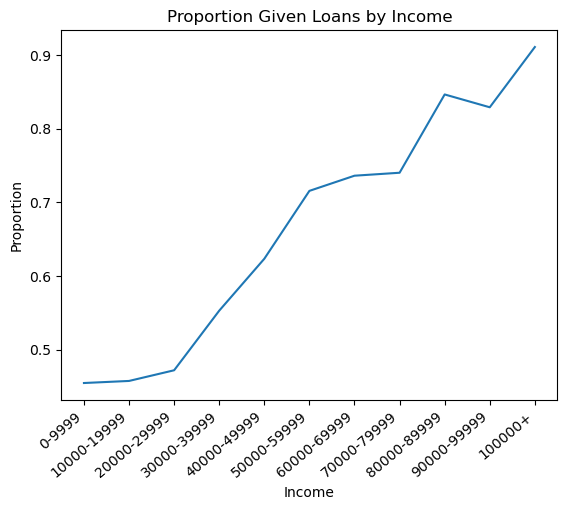

In [24]:
#| code-fold: true
#| label: fig-income-loans
#| fig-cap: Expected loans by income level.

income_bins = np.concatenate((np.arange(-1, 100000, 10000), [2000000]))
income_labels = []

for i in range(len(income_bins)-2):
    income_labels = income_labels + [f'{income_bins[i]+1}-{income_bins[i+1]}']

income_labels = income_labels + ['100000+']


def get_income_class(df):
    df_ = df.copy()
    df_["income_level"] = pd.cut(x = df_['person_income'], bins = income_bins, labels = income_labels)
    return df_

df_test = get_income_class(df_test)

income_level_loans = 1-(df_test.groupby(['income_level'])['y_pred'].sum() / df_test.groupby(['income_level']).size())

loan_income_plt = sns.lineplot(income_level_loans)
loan_income_plt.set_xticklabels(loan_income_plt.get_xticklabels(), rotation=40, ha="right")
loan_income_plt.set(xlabel = 'Income',
                    ylabel = 'Proportion',
                    title = 'Proportion Given Loans by Income');

From @fig-income-loans, we can see that as income level increases, more prospective borrowers are approved for loans. This makes sense, since higher income individuals are more likely to pay back loans. However, it is a bit worrying that lower income individuals will have a hard time getting loans, since they may be the ones that need it the most.

## Summary



In this study, I built an automated decision-making system for loans. I optimized the predicted expected profit per loan for the bank by giving each prospective borrower a score(@eq-score) and then choosing a threshold to determine the borrowers that would receive a loan. Afterwards, I analyzed my model for biases by age group, loan intents, and income level.

By using the features `loan_int_rate`, `loan_percent_income`, `int_percent_income`, and `person_home_ownership`, the model produced an expected ouput of about $1714.51. This surpasses the base profit by about $895.39, an approximately 209% increase in profit.

Furthermore, analysis of my model showed that it approves fewer loans to prospective borrowers over the age of 60, borrowers who intend to take a loan for education and venture, and borrowers with lower income. I also specifically analyzed the impact my model had on borrowers who are intending to take a loan out for medical reasons and found that there was a slight, but not a significant drop in loans approved. Lastly, I discussed why my model would've been unfair for borrowers looking to receive a medical loan if my model had a bias against them. 